In [98]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy 
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
from io import StringIO
from mst_clustering import MSTClustering

In [99]:
k = 3
m = 300
m_cluster_sample_size = int(m/3)
normal_stdvar = 0.04

In [100]:
#Set up random generation object
rng = np.random.default_rng()

#generate m random points in the square [0,1]*[0,1]
#Four sets of points are generated by different normal distributions.
#Three represent "clusterable" points, and a fourth is just noise.
#The sum of the four sets are of length "m"
points_cluster_1 = rng.normal(
    loc=(0, 0), 
    scale=normal_stdvar, 
    size=(m_cluster_sample_size,2))

points_cluster_2 = rng.normal(
    loc=(0, 0.8), 
    scale=normal_stdvar, 
    size=(m_cluster_sample_size,2))

points_cluster_3 = rng.normal(
    loc=(0.5, 0.5), 
    scale=normal_stdvar, 
    size=(m_cluster_sample_size,2))

points = np.concatenate((points_cluster_1, points_cluster_2, points_cluster_3))
#We normalize the points between [0,1]*[0,1], just in case the generators made points out of the scope.
points = (points-np.min(points))/(np.max(points)-np.min(points))

#generate matrix distance
dist = [[math.sqrt((i[0]-j[0])**2+(i[1]-j[1])**2) for i in points] for j in points]
print(len(dist[3]))


300


Text(0.5, 1.0, 'K means solution')

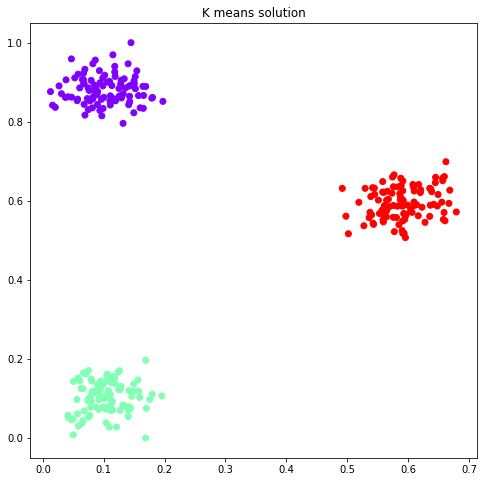

In [106]:
#Kmeans solution
random_state = 170
y_pred = KMeans(n_clusters=k, random_state=random_state).fit_predict(points)


#print clusters
plt.figure(figsize=(8, 8))


plt.scatter(points[:, 0], points[:, 1], c=y_pred,cmap='rainbow')
plt.title("K means solution")

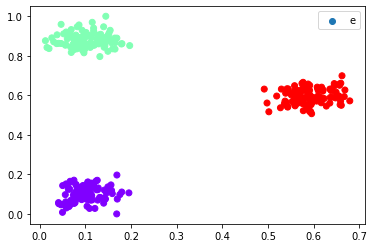

In [121]:
#MST solution
model = MSTClustering(cutoff=k-1)
y_pred_mst = model.fit_predict(points)
plt.scatter(points[:, 0], points[:, 1], c=y_pred_mst, cmap='rainbow');
plt.legend()

In [55]:
#We write the generated data in a .dat AMPL format.
output = open("Kcluster.dat", "w")
output.write('param k:= '+ str(k) + ';')
output.write('\n')
output.write('param m:= '+ str(m) + ';')
output.write('\n')
output.write('param d: ')
for i in range(m):output.write(str(i + 1) + ' ')
output.write(':=')
output.write('\n')
for i in range(m):
    output.write(str(i + 1) + ' ')
    for j in range(m):
        output.write(str(dist[i][j]))
        if(j != m-1):output.write(' ')
    if(i != m-1):output.write('\n')
output.write(';')
output.write('\n')
output.close()


In [ ]:
###AQUI VA LEXECUCIO DEL AMPL DINTRE DEL JUPYTER

In [56]:
#AMPL solution processing

solution_input = open("solution_matrix.txt", "r")
sol = [0 for _ in range(m)]
clusters = []
for i,line in enumerate(solution_input.readlines()):
    if i > 1 and i < m + 3:
        for j,car in enumerate(line.split()):
            if j > 0 and car == "1":
                if not (j - 1) in clusters: clusters.append(j - 1)
                sol[i - 2] = clusters.index(j - 1)

In [115]:
plt.scatter(points[:, 0], points[:, 1], c=sol)
plt.title("LP solution")

NameError: name 'sol' is not defined

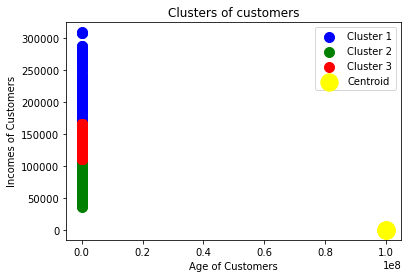

In [113]:
#Multidimensional dataset kmeans implementation
df = pd.read_csv('segmentation-data.csv')
kmeans = KMeans(n_clusters=3, init='k-means++', random_state= 42)  
y_predict= kmeans.fit_predict(df)



In [114]:
df['Age'][y_predict == 0]

3       45
7       35
9       28
18      44
29      63
        ..
1222    34
1227    53
1237    60
1259    38
1297    71
Name: Age, Length: 214, dtype: int64